url: https://cds.climate.copernicus.eu/api
key: 7526687c-52e9-43fe-a3bd-d38e10833c7c

In [1]:
import cdsapi
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline
import os

In [2]:
import sys
print(sys.executable)

/Users/mbolouri/anaconda3/bin/python


2025-08-18 17:50:11,767 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-18 17:50:12,115 INFO Request ID is a19e6172-b1a4-4321-8f8d-577be03d8168
2025-08-18 17:50:12,322 INFO status has been updated to accepted
2025-08-18 17:50:34,126 INFO status has been updated to running
2025-08-18 17:50:45,664 INFO status has been updated to successful


7366f46312badb24b60a0428f47a1241.nc:   0%|          | 0.00/486k [00:00<?, ?B/s]

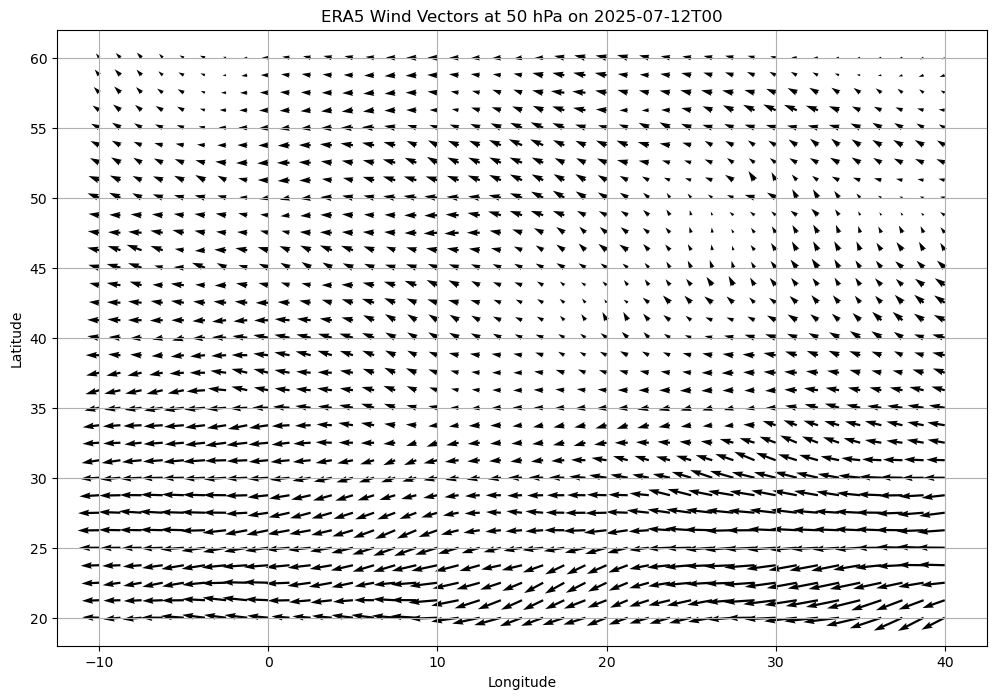

In [3]:
# Replace with your actual file name
filename = "wind_50hpa_era5.nc"
# Select a specific time index
t_index = 0
# Skip every N points to declutter the plot
skip = 5

def download_era5_200hpa_wind(date, area, outfile):
    c = cdsapi.Client()
    c.retrieve(
        'reanalysis-era5-pressure-levels',
        {
            'product_type': 'reanalysis',
            'variable': ['u_component_of_wind', 'v_component_of_wind'],
            'pressure_level': ['50'],
            'year': date[:4],
            'month': date[5:7],
            'day': date[8:10],
            'time': ['00:00', '06:00', '12:00', '18:00'],
            'area': area,  # North/West/South/East. E.g., "60/-10/20/40"
            'format': 'netcdf',
        },
        outfile
    )
    
# Example usage
download_era5_200hpa_wind("2025-07-12", "60/-10/20/40", "wind_50hpa_era5.nc")

# Load the NetCDF file
ds = xr.open_dataset(filename)

# Print available variables and dimensions
# print("\nDataset structure:")
# print(ds)

# Extract variables
u = ds['u']     # u-component of wind (zonal)
v = ds['v']     # v-component of wind (meridional)
time = ds['valid_time']
lat = ds['latitude']
lon = ds['longitude']

# print("\nAvailable times:", time.values)
# print("Latitude range:", lat.min().item(), "to", lat.max().item())
# print("Longitude range:", lon.min().item(), "to", lon.max().item())

# Compute wind speed magnitude (m/s)
wind_speed = np.sqrt(u**2 + v**2)

# Print a sample value
# print(f"\nSample at time = {time[t_index].values}")
# print("u (m/s):", u.isel(valid_time=t_index).values)
# print("v (m/s):", v.isel(valid_time=t_index).values)
# print("Wind speed (m/s):", wind_speed.isel(valid_time=t_index).values)

# Select 2D slices of u and v
u_plot = u.isel(valid_time=t_index, pressure_level=0)
v_plot = v.isel(valid_time=t_index, pressure_level=0)

# Create meshgrid of lon-lat
lon2d, lat2d = np.meshgrid(lon[::skip], lat[::skip])

# Plot
plt.figure(figsize=(12, 8))
plt.quiver(lon2d, lat2d,
           u_plot[::skip, ::skip],
           v_plot[::skip, ::skip],
           scale=700)

plt.title(f"ERA5 Wind Vectors at 50 hPa on {np.datetime_as_string(time[t_index].values, unit='h')}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

Using cached file: era5_50hpa_hourly.nc


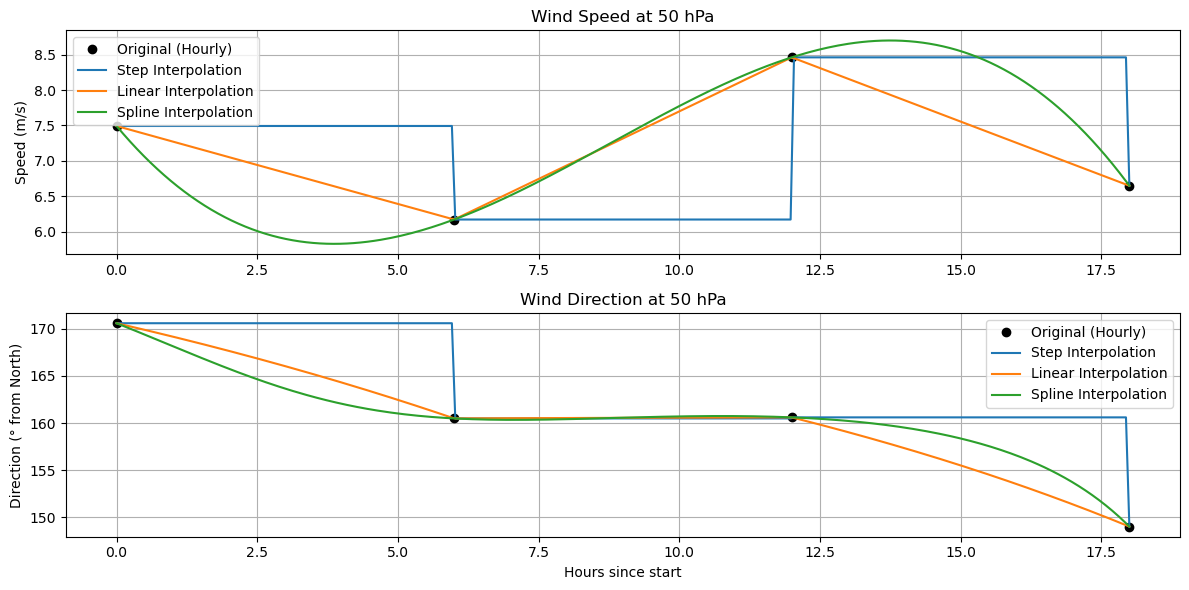

In [4]:
# === Configuration ===
lat, lon = 51.0, 4.0  # Your location
year, month, day = "2025", "07", "12"
level = "50"  # hPa level (~20 km altitude)
output_file = f"era5_{level}hpa_hourly.nc"

# === Step 1: Download hourly ERA5 wind data ===
def download_data():
    if os.path.exists(output_file):
        print(f"Using cached file: {output_file}")
        return
    c = cdsapi.Client()
    c.retrieve(
        "reanalysis-era5-pressure-levels",
        {
            "product_type": "reanalysis",
            "format": "netcdf",
            "variable": ["u_component_of_wind", "v_component_of_wind"],
            "pressure_level": [level],
            "year": year,
            "month": month,
            "day": day,
            "time": [f"{h:02d}:00" for h in range(24)],
            "area": [lat, lon, lat, lon],  # N, W, S, E
        },
        output_file
    )

# === Step 2: Helpers ===
def compute_direction(u, v):
    return (np.degrees(np.arctan2(v, u)) + 360) % 360

def compute_speed(u, v):
    return np.sqrt(u**2 + v**2)

def interpolate_series(times, values, method='linear', resolution=300):
    t0 = times[0]
    hours = np.array([(t - t0) / np.timedelta64(1, 'h') for t in times])
    fine_hours = np.linspace(hours[0], hours[-1], resolution)

    if method == 'step':
        interp_func = interp1d(hours, values, kind='previous', fill_value='extrapolate')
    elif method == 'linear':
        interp_func = interp1d(hours, values, kind='linear', fill_value='extrapolate')
    elif method == 'spline':
        interp_func = CubicSpline(hours, values)
    else:
        raise ValueError("Unsupported method")

    return fine_hours, interp_func(fine_hours)

# === Step 3: Process, interpolate, and plot ===
def process_and_plot():
    ds = xr.open_dataset(output_file)
    u = ds.u.sel(latitude=lat, longitude=lon, method="nearest").values.flatten()
    v = ds.v.sel(latitude=lat, longitude=lon, method="nearest").values.flatten()
    time = ds.valid_time.values

    speed = compute_speed(u, v)
    direction = compute_direction(u, v)

    # Interpolate
    methods = ['step', 'linear', 'spline']
    interp_speed, interp_dir = {}, {}
    for m in methods:
        _, interp_speed[m] = interpolate_series(time, speed, method=m)
        u_m = interpolate_series(time, u, method=m)[1]
        v_m = interpolate_series(time, v, method=m)[1]
        interp_dir[m] = compute_direction(u_m, v_m)

    fine_hours, _ = interpolate_series(time, speed, method='linear')
    hours = [(t - time[0]) / np.timedelta64(1, 'h') for t in time]

    # Plot Wind Speed
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(hours, speed, 'ko', label="Original (Hourly)")
    for m in methods:
        plt.plot(fine_hours, interp_speed[m], label=f"{m.capitalize()} Interpolation")
    plt.title(f"Wind Speed at {level} hPa")
    plt.ylabel("Speed (m/s)")
    plt.legend()
    plt.grid(True)

    # Plot Wind Direction
    plt.subplot(2, 1, 2)
    plt.plot(hours, direction, 'ko', label="Original (Hourly)")
    for m in methods:
        plt.plot(fine_hours, interp_dir[m], label=f"{m.capitalize()} Interpolation")
    plt.title(f"Wind Direction at {level} hPa")
    plt.xlabel("Hours since start")
    plt.ylabel("Direction (° from North)")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# === Run ===
if __name__ == "__main__":
    download_data()
    process_and_plot()

In [5]:
dataset = "reanalysis-era5-pressure-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": [
        "divergence",
        "fraction_of_cloud_cover",
        "geopotential",
        "ozone_mass_mixing_ratio",
        "potential_vorticity",
        "relative_humidity",
        "specific_cloud_ice_water_content",
        "specific_cloud_liquid_water_content",
        "specific_humidity",
        "specific_rain_water_content",
        "specific_snow_water_content",
        "temperature",
        "u_component_of_wind",
        "v_component_of_wind",
        "vertical_velocity",
        "vorticity"
    ],
    "year": ["2024"],
    "month": ["06"],
    "day": ["01"],
    "time": [
        "00:00", "01:00", "02:00",
        "03:00", "04:00", "05:00",
        "06:00", "07:00", "08:00",
        "09:00", "10:00", "11:00",
        "12:00", "13:00", "14:00",
        "15:00", "16:00", "17:00",
        "18:00", "19:00", "20:00",
        "21:00", "22:00", "23:00"
    ],
    "pressure_level": [
        "1", "2", "3",
        "5", "7", "10",
        "20", "30", "50",
        "70", "100", "125",
        "150", "175", "200",
        "225", "250", "300",
        "350", "400", "450",
        "500", "550", "600",
        "650", "700", "750",
        "775", "800", "825",
        "850", "875", "900",
        "925", "950", "975",
        "1000"
    ],
    "data_format": "grib",
    "download_format": "zip"
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-08-18 17:50:48,698 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-18 17:50:49,109 INFO Request ID is 0087f1a2-eba3-4571-8cf8-d96511d7192f
2025-08-18 17:50:49,258 INFO status has been updated to accepted
2025-08-18 17:51:03,198 INFO status has been updated to running


KeyboardInterrupt: 